# This colab notebook trains a classifier on the Camelyon 16 dataset. The weights of this model will be used later on for pretraining the WBC dataset


# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Unzipping dataset into colab instance

In [2]:
!unzip -q '/content/drive/MyDrive/Camelyon.zip' -d '/content/'

# Importing things

In [21]:
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, Subset
import os
from torchvision.datasets import ImageFolder
from torch import nn, optim
from tqdm.auto import tqdm
import torchvision.models as models
import numpy as np

# Parameters


In [22]:
class Config:
    drive_path = "/content/drive/MyDrive"
    datasets_path = f"/content/Camelyon"
    weights_path = f"{drive_path}/weights"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_split = 0.2
    validation_split = 0.3

    learning_rate = 0.01
    weight_decay = 1e-4
    grad_clip = 0.1

    cam_batch_size = 16
    cam_img_resize_target = 224 # from 384 -> 224 (as resnet needs this)

config = Config()

# Util functions


In [23]:
# Functions for plotting graphs
def plot_model_stats(experiment, epochs, training_losses, validation_losses, training_accuracy, validation_accuracy):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Plot data on each subplot and add labels
    axes[0, 0].plot(epochs, training_losses, marker="o", color="red")
    axes[0, 0].set_title(f'{experiment}: Training Loss vs Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Training Loss')

    axes[0, 1].plot(epochs, training_accuracy, marker="o", color="green")
    axes[0, 1].set_title(f'{experiment}: Training Accuracy vs Epochs')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Training Accuracy')

    axes[1, 0].plot(epochs, validation_losses, marker="o", color="red")
    axes[1, 0].set_title(f'{experiment}: Validation Loss vs Epochs')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Validation Loss')

    axes[1, 1].plot(epochs, validation_accuracy, marker="o", color="green")
    axes[1, 1].set_title(f'{experiment}: Validation Accuracy vs Epochs')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()


# Functions needed for debugging dataset related issues

In [24]:
class LocalDebug:
    @staticmethod
    def create_mini_dataset(dataset, num_samples):
        '''
        Function to be used locally for checking if the model runs or not!

        :param dataset:
        :param num_samples:
        :return:
        '''
        subset_indices = torch.randperm(len(dataset))[:num_samples]
        subset_dataset = Subset(dataset, subset_indices)
        return subset_dataset

    @staticmethod
    def calculate_mean_and_std_of_dataset(dataset):
        '''
        Useful when determining what transforms to set

        :param dataset:
        :return:
        '''
        # dataset =  ImageFolder(root=self.path, transform=transforms.ToTensor())

        # Initialize variables to accumulate mean and standard deviation
        mean = torch.zeros(3)
        std = torch.zeros(3)

        # Loop through the dataset to compute mean and standard deviation
        for img, _ in dataset:
            mean += img.mean(1).mean(1)
            std += img.view(3, -1).std(1)

        # Calculate the mean and standard deviation
        mean /= len(dataset)
        std /= len(dataset)

        return (tuple(mean.tolist()), tuple(std.tolist()))

# Dataset wrapper to move tensors to device

In [25]:
'''
Wrapper on top of dataloader to move tensors to device
'''
class DeviceDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True, device=config.device):
        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle
        )
        self.device = device

    def __iter__(self):
        for batch in super().__iter__():
            yield self._move_to_device(batch)

    def _move_to_device(self, batch):
        if isinstance(batch, torch.Tensor):
            return batch.to(self.device)
        elif isinstance(batch, (list, tuple)):
            return [self._move_to_device(item) for item in batch]
        elif isinstance(batch, dict):
            return {key: self._move_to_device(value) for key, value in batch.items()}
        else:
            return batch



# Dataset


In [26]:
'''
This dataset is balanced so no need to do any fancy things
Here all there are only 2 classes normal:0 and tumor:1, we need to one hot encode it as well

'''
class CamelyonDataset:
    def __init__(self, path, batch_size=config.cam_batch_size, resize_to=config.cam_img_resize_target):
        # constants
        self.path = path
        self.batch_size = batch_size
        self.resize_to = resize_to

        # paths
        self.train_path = os.path.join(self.path, "train", "data")
        self.test_path = os.path.join(self.path, "test", "data")
        self.val_path = os.path.join(self.path, "val", "data")

        # transformations
        self.eval_transforms = transforms.Compose([
            transforms.Resize((self.resize_to, self.resize_to)),
            transforms.ToTensor()
        ])

        self.train_transforms = [
            # basic transformation
            self.eval_transforms,
            # transformation with flips
            transforms.Compose([
                transforms.Resize((self.resize_to, self.resize_to)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor()
            ]),
            # transformation with rotation
            transforms.Compose([
                transforms.Resize((self.resize_to, self.resize_to)),
                transforms.RandomRotation(degrees=15),
                transforms.ToTensor()
            ]),
            # transformation with rotation & flips
            transforms.Compose([
                transforms.Resize((self.resize_to, self.resize_to)),
                transforms.RandomRotation(degrees=15),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()
            ])
        ]

        # create dataset
        self.validation_dataset = self.get_val_dataset()
        self.test_dataset = self.get_test_dataset()
        self.train_dataset = self.get_train_dataset_with_augmentation()

    def get_train_dataset_with_augmentation(self):
        '''

        :return: Concatenated dataset with all augmentations
        '''
        augmentations = []
        for transformation in self.train_transforms:
            augmentations.append(self.get_train_dataset(transformation))
        return ConcatDataset(augmentations)

    def get_train_dataset(self, transformation):
        image_folder = ImageFolder(root=self.train_path, transform=transformation)

        # Uncomment for local testing
        # image_folder = LocalDebug.create_mini_dataset(image_folder, 5)

        return image_folder

    def get_test_dataset(self):
        image_folder = ImageFolder(root=self.test_path, transform=self.eval_transforms)

        # Uncomment for local testing
        # image_folder = LocalDebug.create_mini_dataset(image_folder, 5)

        return image_folder

    def get_val_dataset(self):
        image_folder = ImageFolder(root=self.val_path, transform=self.eval_transforms)

        # Uncomment for local testing
        # image_folder = LocalDebug.create_mini_dataset(image_folder, 5)

        return image_folder

    def get_dataloaders(self):
        '''
        :return: the Train, Val and test dataloaders
        '''
        # Create DataLoaders for validation and test sets
        return DeviceDataLoader(self.train_dataset, self.batch_size), DeviceDataLoader(self.test_dataset,self.batch_size), DeviceDataLoader(self.validation_dataset, self.batch_size)

# Generic Trainer


In [27]:
class Trainer:
    def __init__(self, name, dataset, model, save_dir, device=config.device):
        '''

        :param name: name of the experiement
        :param dataset: the dataset object which implements the method get_dataloaders()
        :param model: the model architecture used
        :param loss_criterion: the loss function used
        :param save_dir: path where the model weights can be saved
        '''
        self.name = name
        self.dataset = dataset
        self.save_dir = save_dir

        # create the directory if it doesnt exist!
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(os.path.join(self.save_dir, self.name), exist_ok=True)

        self.model = model
        self.device = device
        self.batch_size = self.dataset.batch_size

        # get loaders (each of which already moves tensors to device)
        self.train_loader, self.test_loader, self.val_loader = self.dataset.get_dataloaders()

        # Adam optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # find the most recent file and return the path
    def get_model_checkpoint_path(self, epoch_num=None):
        directory = os.path.join(self.save_dir, self.name)
        if epoch_num == None:
            # Get a list of all files in the directory
            files = os.listdir(directory)

            # Filter out only the files (exclude directories)
            files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

            # Sort the files by their modification time in descending order (most recent first)
            files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

            # Get the name of the most recently added file
            model_file = files[0] if files else None
        else:
            model_file = f"model_epoch_{epoch_num}.pt"
        return os.path.join(directory, model_file)

    # main train code
    def train(self,
              num_epochs,
              resume_epoch_num=None,
              load_from_checkpoint=False,
              epoch_saver_count=2):
        '''

        :param num_epochs:
        :param resume_epoch_num: just the name of the model checkpoint
        :param load_from_checkpoint: boolean indicating if we need to load from checkpoint or not
        :param epoch_saver_count:
        :return:
        '''
        torch.cuda.empty_cache()

        # initialize the params from the saved checkpoint
        self.init_params_from_checkpoint_hook(load_from_checkpoint, resume_epoch_num)

        # set up scheduler
        self.init_scheduler_hook(num_epochs)

        # Custom progress bar for total epochs with color and displaying average epoch loss
        total_progress_bar = tqdm(
            total=num_epochs, desc=f"Total Epochs", position=0,
            bar_format="{desc}: {percentage}% |{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]",
            dynamic_ncols=True, ncols=100, colour='red'
        )

        # Train loop
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            # Custom progress bar for each epoch with color
            epoch_progress_bar = tqdm(
                total=len(self.train_loader),
                desc=f"Epoch {epoch + 1}/{self.start_epoch + num_epochs}",
                position=1,
                leave=False,
                dynamic_ncols=True,
                ncols=100,
                colour='green'
            )

            # set model to train mode
            self.model.train()

            # set the epoch training loss
            epoch_training_loss = 0.0

            # iterate over each batch
            for batch_idx, data in enumerate(self.train_loader):
                loss = self.calculate_loss_hook(data)
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_value_(self.model.parameters(), config.grad_clip)

                self.optimizer.step()
                self.optimizer.zero_grad()

                # scheduler update
                if self.scheduler:
                    self.scheduler.step()

                # add to epoch loss
                epoch_training_loss += loss.item()

                # Update the epoch progress bar (overwrite in place)
                postfix = {
                    "loss": loss.item()
                }

                # e.g. computes things like accuracy
                batch_stats = self.calculate_train_batch_stats_hook()

                postfix.update(batch_stats)

                epoch_progress_bar.set_postfix(postfix)
                epoch_progress_bar.update(1)

            # close the epoch progress bar
            epoch_progress_bar.close()

            # calculate average epoch train statistics
            avg_train_stats = self.calculate_avg_train_stats_hook(epoch_training_loss)

            # calculate validation statistics
            avg_val_stats = self.validation_hook()

            # Store running history
            self.store_running_history_hook(epoch, avg_train_stats, avg_val_stats)

            # Show epoch stats (NOTE: Can clear the batch stats here)
            print(f"# Epoch {epoch+1}")
            epoch_postfix = self.calculate_and_print_epoch_stats_hook(avg_train_stats, avg_val_stats)


            # Update the total progress bar
            total_progress_bar.set_postfix(epoch_postfix)

            # Close tqdm bar
            total_progress_bar.update(1)

            # Save model checkpoint periodically
            need_to_save_model_checkpoint = (epoch + 1) % epoch_saver_count == 0
            if need_to_save_model_checkpoint:
                print(f"Going to save model {self.name} @ Epoch:{epoch + 1}")
                self.save_model_checkpoint_hook(epoch, avg_train_stats, avg_val_stats)

            print("-" * 60)

        # Close the total progress bar
        total_progress_bar.close()

        # Return the current state
        return self.get_current_running_history_state_hook()

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_checkpoint):
        raise NotImplementedError("Need to implement hook for initializing params from checkpoint")

    def init_scheduler_hook(self, num_epochs):
        # optimizer is already defined in the super class constructor at this point
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
        )
    def calculate_loss_hook(self, data):
        raise NotImplementedError("Need to implement hook for computing the custom loss value")

    def calculate_train_batch_stats_hook(self):
        raise NotImplementedError("Need to implement this hook for computing the batch statistics like accuracy")

    def calculate_avg_train_stats_hook(self):
        raise NotImplementedError(
            "Need to implement this hook for calculating train loss and train accuracy if applicable")

    def validation_hook(self):
        raise NotImplementedError("Need to implement this hook to calculate the validation stats")

    def calculate_and_print_epoch_stats_hook(self):
        raise NotImplementedError(
            "Need to implement this hook to calculate and print the epoch statistics and return the postfix dictinoary")

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        raise NotImplementedError("Need to implement this hook to store the running history of stats for each epoch")

    def save_model_checkpoint_hook(self, epoch, avg_train_stats, avg_val_stats):
        raise NotImplementedError("Need to implement this hook to save the model checkpoints")

    def get_current_running_history_state_hook(self):
        raise NotImplementedError("Need to implement this hook to return the history after training the model")


# Subclassing the Generic Trainer for classification tasks

In [28]:
class ClassificationTrainer(Trainer):
    def __init__(self, name, dataset, model, save_dir, num_classes):
        super().__init__(name, dataset, model, save_dir)

        # structured similarity index
        self.loss_criterion = nn.CrossEntropyLoss()

        # Values which can change based on loaded checkpoint
        self.start_epoch = 0
        self.epoch_numbers = []
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []

        self.num_classes = num_classes
        self.train_correct_predictions = 0
        self.train_total_batches = 0

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_epoch_num):
        if load_from_checkpoint:
            # NOTE: resume_epoch_num can be None here if we want to load from the most recently saved checkpoint!
            checkpoint_path = self.get_model_checkpoint_path(resume_epoch_num)
            checkpoint = torch.load(checkpoint_path)

            # load previous state
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            # Things we are keeping track of
            self.start_epoch = checkpoint['epoch']
            self.epoch_numbers = checkpoint['epoch_numbers']
            self.training_losses = checkpoint['training_losses']
            self.validation_losses = checkpoint['validation_losses']
            self.training_accuracies = checkpoint['training_accuracies']
            self.validation_accuracies = checkpoint['validation_accuracies']

            print(f"Model checkpoint for {self.name} is loaded from {checkpoint_path}!")

    def calculate_train_batch_stats_hook(self):
        # Note: No accuracy to compute so leaving it as is.
        batch_stats = {
            "batch_acc": self.batch_accuracy
        }
        self.batch_accuracy = 0
        return batch_stats

    def calculate_avg_train_stats_hook(self, epoch_training_loss):
        # NOTE: no need to calculate avg training accuracy here
        avg_training_loss_for_epoch = epoch_training_loss / len(self.train_loader)
        avg_training_accuracy = self.train_correct_predictions / self.train_total_batches

        epoch_train_stats = {
            "avg_training_loss": avg_training_loss_for_epoch,
            "avg_training_accuracy": avg_training_accuracy
        }

        # reset
        self.train_correct_predictions = 0
        self.train_total_batches = 0

        return epoch_train_stats

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        self.epoch_numbers.append(epoch + 1)
        self.training_losses.append(avg_train_stats["avg_training_loss"])
        self.training_accuracies.append(avg_train_stats["avg_training_accuracy"])

        self.validation_losses.append(avg_val_stats["avg_val_loss_for_epoch"])
        self.validation_accuracies.append(avg_val_stats["avg_val_accuracy"])

    def calculate_and_print_epoch_stats_hook(self, avg_train_stats, avg_val_stats):
        print(
            f"Epoch loss: {avg_train_stats['avg_training_loss']} | Train Acc: {avg_train_stats['avg_training_accuracy']} | Val Acc: {avg_val_stats['avg_val_accuracy']} | Val loss: {avg_val_stats['avg_val_loss_for_epoch']}")

        return {
            "epoch_loss": avg_train_stats['avg_training_loss'],
            "val_loss": avg_val_stats['avg_val_loss_for_epoch'],
            "train_acc": avg_train_stats['avg_training_accuracy'],
            "val_acc": avg_val_stats['avg_val_accuracy']
        }

    def save_model_checkpoint_hook(self, epoch, avg_train_stats, avg_val_stats):
        # set it to train mode to save the weights (but doesn't matter apparently!)
        self.model.train()

        # create the directory if it doesn't exist
        model_save_directory = os.path.join(self.save_dir, self.name)
        os.makedirs(model_save_directory, exist_ok=True)

        # Checkpoint the model at the end of each epoch
        checkpoint_path = os.path.join(model_save_directory, f'model_epoch_{epoch + 1}.pt')
        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'epoch': epoch + 1,
                'epoch_numbers': self.epoch_numbers,
                'training_losses': self.training_losses,
                'training_accuracies': self.training_accuracies,
                'validation_losses': self.validation_losses,
                'validation_accuracies': self.validation_accuracies
            },
            checkpoint_path
        )
        print(f"Saved the model checkpoint for experiment {self.name} for epoch {epoch + 1}")

    def get_current_running_history_state_hook(self):
        return self.epoch_numbers, self.training_losses, self.training_accuracies, self.validation_losses, self.validation_accuracies

    # util code
    def one_hot(self, labels):
        # Create an empty one-hot tensor
        one_hot_tensor = torch.zeros((labels.size(0), self.num_classes), dtype=torch.float32).to(config.device)

        # Use scatter to fill in the one-hot tensor
        one_hot_tensor.scatter_(1, labels.view(-1, 1), 1)

        return one_hot_tensor

# Camelyon Trainer

In [29]:
class CamClassifierTrainer(ClassificationTrainer):
    def __init__(self, name, dataset, model, save_dir, num_classes=2):
        super().__init__(name, dataset, model, save_dir, num_classes)

    # hooks
    def calculate_loss_hook(self, data):
        images, labels = data
        one_hot_labels = self.one_hot(labels)
        _, output_logits = self.model(images)
        loss = self.loss_criterion(output_logits, one_hot_labels)

        # compute the batch stats right here and save it
        output_probs = nn.Softmax(dim=1)(output_logits)
        predicted = torch.argmax(output_probs, 1)
        batch_correct_predictions = (predicted == labels).sum().item()
        batch_size = labels.size(0)

        # store the accuracies
        self.batch_accuracy = batch_correct_predictions / batch_size
        self.train_correct_predictions += batch_correct_predictions
        self.train_total_batches += labels.size(0)

        return loss

    def validation_hook(self):
        '''
        :return: avg val loss for that epoch
        '''
        val_loss = 0.0
        val_correct_predictions = 0
        total_val_samples = 0

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for val_batch_idx, val_data in enumerate(self.val_loader):
                val_images, val_labels = val_data
                one_hot_val_labels = self.one_hot(val_labels)

                _, val_logits = self.model(val_images)

                val_loss += self.loss_criterion(val_logits, one_hot_val_labels).item()

                # Compute validation accuracy for this batch
                val_probs = nn.Softmax(dim=1)(val_logits)
                val_predicted = torch.argmax(val_probs, dim=1)
                total_val_samples += val_labels.size(0)
                val_correct_predictions += (val_predicted == val_labels).sum().item()

        # Calculate average validation loss for the epoch
        avg_val_loss_for_epoch = val_loss / len(self.val_loader)

        # Calculate validation accuracy for the epoch
        avg_val_accuracy = val_correct_predictions / total_val_samples

        return {
            "avg_val_loss_for_epoch": avg_val_loss_for_epoch,
            "avg_val_accuracy": avg_val_accuracy
        }

    def test_model(self):
        test_loss = 0.0
        test_correct_predictions = 0
        total_test_samples = 0

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for test_batch_idx, test_data in enumerate(self.test_loader):
                test_images, test_labels = test_data
                one_hot_test_labels = self.one_hot(test_labels)

                _, test_logits = self.model(test_images)

                test_loss += self.loss_criterion(test_logits, one_hot_test_labels).item()

                # Compute validation accuracy for this batch
                test_probs = nn.Softmax(dim=1)(test_logits)
                test_predicted = torch.argmax(test_probs, dim=1)
                total_test_samples += test_labels.size(0)
                test_correct_predictions += (test_predicted == test_labels).sum().item()

        # Calculate average validation loss for the epoch
        avg_test_loss = test_loss / len(self.test_loader)

        # Calculate validation accuracy for the epoch
        avg_test_accuracy = test_correct_predictions / total_test_samples

        return {
            "test_loss": avg_test_loss,
            "test_accuracy": avg_test_accuracy
        }

# Model


In [30]:
class CamelyonClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.num_classes = num_classes

        self.conv1 = self.conv_and_batch_norm_block(3, 64)
        self.conv2 = self.conv_and_batch_norm_block(64, 128, pool=True)
        self.res1 = self.conv_and_batch_norm_block(128, 128)
        self.res2 = self.conv_and_batch_norm_block(128, 128)

        self.conv3 = self.conv_and_batch_norm_block(128, 256, pool=True)
        self.conv4 = self.conv_and_batch_norm_block(256, 512, pool=True)

        self.res3 = self.conv_and_batch_norm_block(512, 512)
        self.res4 = self.conv_and_batch_norm_block(512, 512)

        self.linear_stack = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(32768, 2048),
            nn.ReLU(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 5),
            nn.ReLU()
        )

        # Replace the initial layers with a pre-trained ResNet-18 backbone
        self.resnet18 = models.resnet18(pretrained=True)

        #set to non trainable
        self.resnet18.eval()
        for param in self.resnet18.parameters():
            param.requires_grad = False

        #remove the fully connected layer
        self.resnet18.fc = nn.Identity()  # Remove the fully connected layer (classifier)

        self.resnet_linear_stack = nn.Sequential(
            nn.Linear(512, 32),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 5),
            nn.ReLU()
        )

        self.predictor = nn.Sequential(
            nn.Linear(5, self.num_classes)
        )

    def conv_and_batch_norm_block(self, in_channels, out_channels, pool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def forward(self,x):
        # Pass input through the ResNet-18 backbone
        features = self.resnet18(x)

        # Continue with the linear stack and predictor
        linear_stack = self.resnet_linear_stack(features)
        predictor = self.predictor(linear_stack)
        return linear_stack, predictor

    def old_forward(self, x):
        '''
        This contains the old model architecture

        :param x:
        :return:
        '''
        #Assumes that x is of shape (b, 3, 256,256)
        out = self.conv1(x)  # shape (b,64,256,256)
        out1 = self.conv2(out)  # shape (b,128,128,128)
        out = self.res1(out1) + out1  # skip connections, shape (b,128,128,128)

        out = out1 + self.res2(out) + out  # multi skip connections, shape (b,128,128,128)
        out = self.conv3(out)  # shape is (b,256,64,64)
        out2 = self.conv4(out)  # shape is (b,512,32,32)

        out = self.res3(out2) + out2  # skip connections, shape is (b,512,32,32)
        out = out2 + self.res4(out) + out  # multi skip connections, shape is (b,512,32,32)

        linear_stack = self.linear_stack(out)
        predictor = self.predictor(linear_stack)
        return linear_stack, predictor

# Creating the dataset

In [31]:
path = os.path.abspath(config.datasets_path)
cam_dataset = CamelyonDataset(path)

# Training code

In [44]:
name = "camelyon_classifier"
model = CamelyonClassifier().to(config.device)
save_dir = os.path.abspath(config.weights_path)
cam_trainer = CamClassifierTrainer(name, cam_dataset, model, save_dir)

In [46]:
epoch_numbers, training_losses, training_accuracies, validation_losses, validation_accuracies = cam_trainer.train(40, epoch_saver_count=2)

Total Epochs: 0.0% |          | 0/40 [00:00<?, ?it/s]

Epoch 1/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 1
Epoch loss: 0.5383487086200235 | Train Acc: 0.7357660455486542 | Val Acc: 0.8425925925925926 | Val loss: 0.45845165848731995
------------------------------------------------------------


Epoch 2/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 2
Epoch loss: 0.40262576297449704 | Train Acc: 0.8321788413098237 | Val Acc: 0.8333333333333334 | Val loss: 0.3740851410797664
Going to save model camelyon_classifier @ Epoch:2
Saved the model checkpoint for experiment camelyon_classifier for epoch 2
------------------------------------------------------------


Epoch 3/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 3
Epoch loss: 0.36155514404102784 | Train Acc: 0.8438287153652393 | Val Acc: 0.8518518518518519 | Val loss: 0.3725560648100717
------------------------------------------------------------


Epoch 4/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 4
Epoch loss: 0.33269894879367484 | Train Acc: 0.8576826196473551 | Val Acc: 0.8425925925925926 | Val loss: 0.40379817358085085
Going to save model camelyon_classifier @ Epoch:4
Saved the model checkpoint for experiment camelyon_classifier for epoch 4
------------------------------------------------------------


Epoch 5/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 5
Epoch loss: 0.4315309119247012 | Train Acc: 0.8104534005037783 | Val Acc: 0.8518518518518519 | Val loss: 0.41112970241478514
------------------------------------------------------------


Epoch 6/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 6
Epoch loss: 0.3929585535921643 | Train Acc: 0.8378463476070529 | Val Acc: 0.8425925925925926 | Val loss: 0.39731630257197786
Going to save model camelyon_classifier @ Epoch:6
Saved the model checkpoint for experiment camelyon_classifier for epoch 6
------------------------------------------------------------


Epoch 7/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 7
Epoch loss: 0.37526890002752666 | Train Acc: 0.8334382871536524 | Val Acc: 0.8425925925925926 | Val loss: 0.6479609257408551
------------------------------------------------------------


Epoch 8/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 8
Epoch loss: 0.3812776543200016 | Train Acc: 0.8350125944584383 | Val Acc: 0.8611111111111112 | Val loss: 0.49580116144248415
Going to save model camelyon_classifier @ Epoch:8
Saved the model checkpoint for experiment camelyon_classifier for epoch 8
------------------------------------------------------------


Epoch 9/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 9
Epoch loss: 0.4488510298706479 | Train Acc: 0.7899874055415617 | Val Acc: 0.8148148148148148 | Val loss: 0.40130770206451416
------------------------------------------------------------


Epoch 10/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 10
Epoch loss: 0.44729860306684693 | Train Acc: 0.8060453400503779 | Val Acc: 0.8148148148148148 | Val loss: 0.4404791370034218
Going to save model camelyon_classifier @ Epoch:10
Saved the model checkpoint for experiment camelyon_classifier for epoch 10
------------------------------------------------------------


Epoch 11/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 11
Epoch loss: 0.39036879673525315 | Train Acc: 0.8214735516372796 | Val Acc: 0.7962962962962963 | Val loss: 0.9610027713435036
------------------------------------------------------------


Epoch 12/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 12
Epoch loss: 0.3861227238822223 | Train Acc: 0.8236775818639799 | Val Acc: 0.8425925925925926 | Val loss: 0.6712490377415504
Going to save model camelyon_classifier @ Epoch:12
Saved the model checkpoint for experiment camelyon_classifier for epoch 12
------------------------------------------------------------


Epoch 13/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 13
Epoch loss: 0.4233029460038372 | Train Acc: 0.7789672544080605 | Val Acc: 0.8148148148148148 | Val loss: 0.6424290112086705
------------------------------------------------------------


Epoch 14/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 14
Epoch loss: 0.4160137936173372 | Train Acc: 0.7953400503778337 | Val Acc: 0.8425925925925926 | Val loss: 0.5725448514733996
Going to save model camelyon_classifier @ Epoch:14
Saved the model checkpoint for experiment camelyon_classifier for epoch 14
------------------------------------------------------------


Epoch 15/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 15
Epoch loss: 0.4459118506866484 | Train Acc: 0.7660579345088161 | Val Acc: 0.7962962962962963 | Val loss: 0.5433842241764069
------------------------------------------------------------


Epoch 16/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 16
Epoch loss: 0.3911372077599842 | Train Acc: 0.7629093198992444 | Val Acc: 0.8148148148148148 | Val loss: 0.6084388281617846
Going to save model camelyon_classifier @ Epoch:16
Saved the model checkpoint for experiment camelyon_classifier for epoch 16
------------------------------------------------------------


Epoch 17/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 17
Epoch loss: 0.42800976897603904 | Train Acc: 0.7880982367758187 | Val Acc: 0.8425925925925926 | Val loss: 0.9879169464111328
------------------------------------------------------------


Epoch 18/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 18
Epoch loss: 0.5041395904842633 | Train Acc: 0.756926952141058 | Val Acc: 0.8518518518518519 | Val loss: 0.7647690091814313
Going to save model camelyon_classifier @ Epoch:18
Saved the model checkpoint for experiment camelyon_classifier for epoch 18
------------------------------------------------------------


Epoch 19/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 19
Epoch loss: 0.4512438488815298 | Train Acc: 0.7811712846347607 | Val Acc: 0.7962962962962963 | Val loss: 0.8172198363712856
------------------------------------------------------------


Epoch 20/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 20
Epoch loss: 0.4291441128331812 | Train Acc: 0.7651133501259446 | Val Acc: 0.8333333333333334 | Val loss: 0.8102924738611493
Going to save model camelyon_classifier @ Epoch:20
Saved the model checkpoint for experiment camelyon_classifier for epoch 20
------------------------------------------------------------


Epoch 21/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 21
Epoch loss: 0.4018102214489151 | Train Acc: 0.7808564231738035 | Val Acc: 0.8055555555555556 | Val loss: 0.5915130589689527
------------------------------------------------------------


Epoch 22/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 22
Epoch loss: 0.40567695858640285 | Train Acc: 0.7899874055415617 | Val Acc: 0.8240740740740741 | Val loss: 0.7443364773477826
Going to save model camelyon_classifier @ Epoch:22
Saved the model checkpoint for experiment camelyon_classifier for epoch 22
------------------------------------------------------------


Epoch 23/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 23
Epoch loss: 0.40231091355034454 | Train Acc: 0.8198992443324937 | Val Acc: 0.8425925925925926 | Val loss: 1.0945797903197152
------------------------------------------------------------


Epoch 24/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 24
Epoch loss: 0.4539467782605833 | Train Acc: 0.7783375314861462 | Val Acc: 0.8148148148148148 | Val loss: 0.6414922944137028
Going to save model camelyon_classifier @ Epoch:24
Saved the model checkpoint for experiment camelyon_classifier for epoch 24
------------------------------------------------------------


Epoch 25/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 25
Epoch loss: 0.4039429607777739 | Train Acc: 0.8173803526448362 | Val Acc: 0.7870370370370371 | Val loss: 0.7995758908135551
------------------------------------------------------------


Epoch 26/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 26
Epoch loss: 0.3562492150158139 | Train Acc: 0.8173803526448362 | Val Acc: 0.8518518518518519 | Val loss: 0.8455489192690168
Going to save model camelyon_classifier @ Epoch:26
Saved the model checkpoint for experiment camelyon_classifier for epoch 26
------------------------------------------------------------


Epoch 27/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 27
Epoch loss: 0.3695636631256372 | Train Acc: 0.8299748110831234 | Val Acc: 0.8240740740740741 | Val loss: 0.7386678776570729
------------------------------------------------------------


Epoch 28/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 28
Epoch loss: 0.38720078751369935 | Train Acc: 0.8287153652392947 | Val Acc: 0.8425925925925926 | Val loss: 1.1686692285750593
Going to save model camelyon_classifier @ Epoch:28
Saved the model checkpoint for experiment camelyon_classifier for epoch 28
------------------------------------------------------------


Epoch 29/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 29
Epoch loss: 0.3832875940218643 | Train Acc: 0.8271410579345088 | Val Acc: 0.8611111111111112 | Val loss: 0.767174265214375
------------------------------------------------------------


Epoch 30/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 30
Epoch loss: 0.36696321790541836 | Train Acc: 0.8331234256926953 | Val Acc: 0.8425925925925926 | Val loss: 0.7394392650042262
Going to save model camelyon_classifier @ Epoch:30
Saved the model checkpoint for experiment camelyon_classifier for epoch 30
------------------------------------------------------------


Epoch 31/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 31
Epoch loss: 0.37162555482743975 | Train Acc: 0.8409949622166247 | Val Acc: 0.8611111111111112 | Val loss: 1.2538916085447585
------------------------------------------------------------


Epoch 32/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 32
Epoch loss: 0.3721923518495344 | Train Acc: 0.8340680100755667 | Val Acc: 0.8518518518518519 | Val loss: 0.8350794017314911
Going to save model camelyon_classifier @ Epoch:32
Saved the model checkpoint for experiment camelyon_classifier for epoch 32
------------------------------------------------------------


Epoch 33/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 33
Epoch loss: 0.3445616829110749 | Train Acc: 0.8454030226700252 | Val Acc: 0.8611111111111112 | Val loss: 0.9424763811486108
------------------------------------------------------------


Epoch 34/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 34
Epoch loss: 0.3509656034746961 | Train Acc: 0.8334382871536524 | Val Acc: 0.8611111111111112 | Val loss: 0.8419761082955769
Going to save model camelyon_classifier @ Epoch:34
Saved the model checkpoint for experiment camelyon_classifier for epoch 34
------------------------------------------------------------


Epoch 35/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 35
Epoch loss: 0.38209605988246115 | Train Acc: 0.8343828715365239 | Val Acc: 0.8518518518518519 | Val loss: 0.8155511713453701
------------------------------------------------------------


Epoch 36/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 36
Epoch loss: 0.34432875784348005 | Train Acc: 0.845088161209068 | Val Acc: 0.8611111111111112 | Val loss: 0.9193092488816806
Going to save model camelyon_classifier @ Epoch:36
Saved the model checkpoint for experiment camelyon_classifier for epoch 36
------------------------------------------------------------


Epoch 37/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 37
Epoch loss: 0.36638730214019516 | Train Acc: 0.8586272040302267 | Val Acc: 0.8611111111111112 | Val loss: 0.823090917297772
------------------------------------------------------------


Epoch 38/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 38
Epoch loss: 0.31752482711819546 | Train Acc: 0.8570528967254408 | Val Acc: 0.8611111111111112 | Val loss: 0.8407795067344394
Going to save model camelyon_classifier @ Epoch:38
Saved the model checkpoint for experiment camelyon_classifier for epoch 38
------------------------------------------------------------


Epoch 39/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 39
Epoch loss: 0.33835111719429795 | Train Acc: 0.8532745591939547 | Val Acc: 0.8611111111111112 | Val loss: 0.8674692809581757
------------------------------------------------------------


Epoch 40/40:   0%|          | 0/199 [00:00<?, ?it/s]

# Epoch 40
Epoch loss: 0.3522937252144119 | Train Acc: 0.8557934508816121 | Val Acc: 0.8518518518518519 | Val loss: 0.9333379013197762
Going to save model camelyon_classifier @ Epoch:40
Saved the model checkpoint for experiment camelyon_classifier for epoch 40
------------------------------------------------------------


## Training for more epochs if required

In [47]:
# epoch_numbers, training_losses, training_accuracies, validation_losses, validation_accuracies = cam_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=10)

# Testing the model

In [48]:
test_stats = cam_trainer.test_model()

In [49]:
test_stats

{'test_loss': 0.7637413647025824, 'test_accuracy': 0.8611111111111112}

# Plotting the graphs

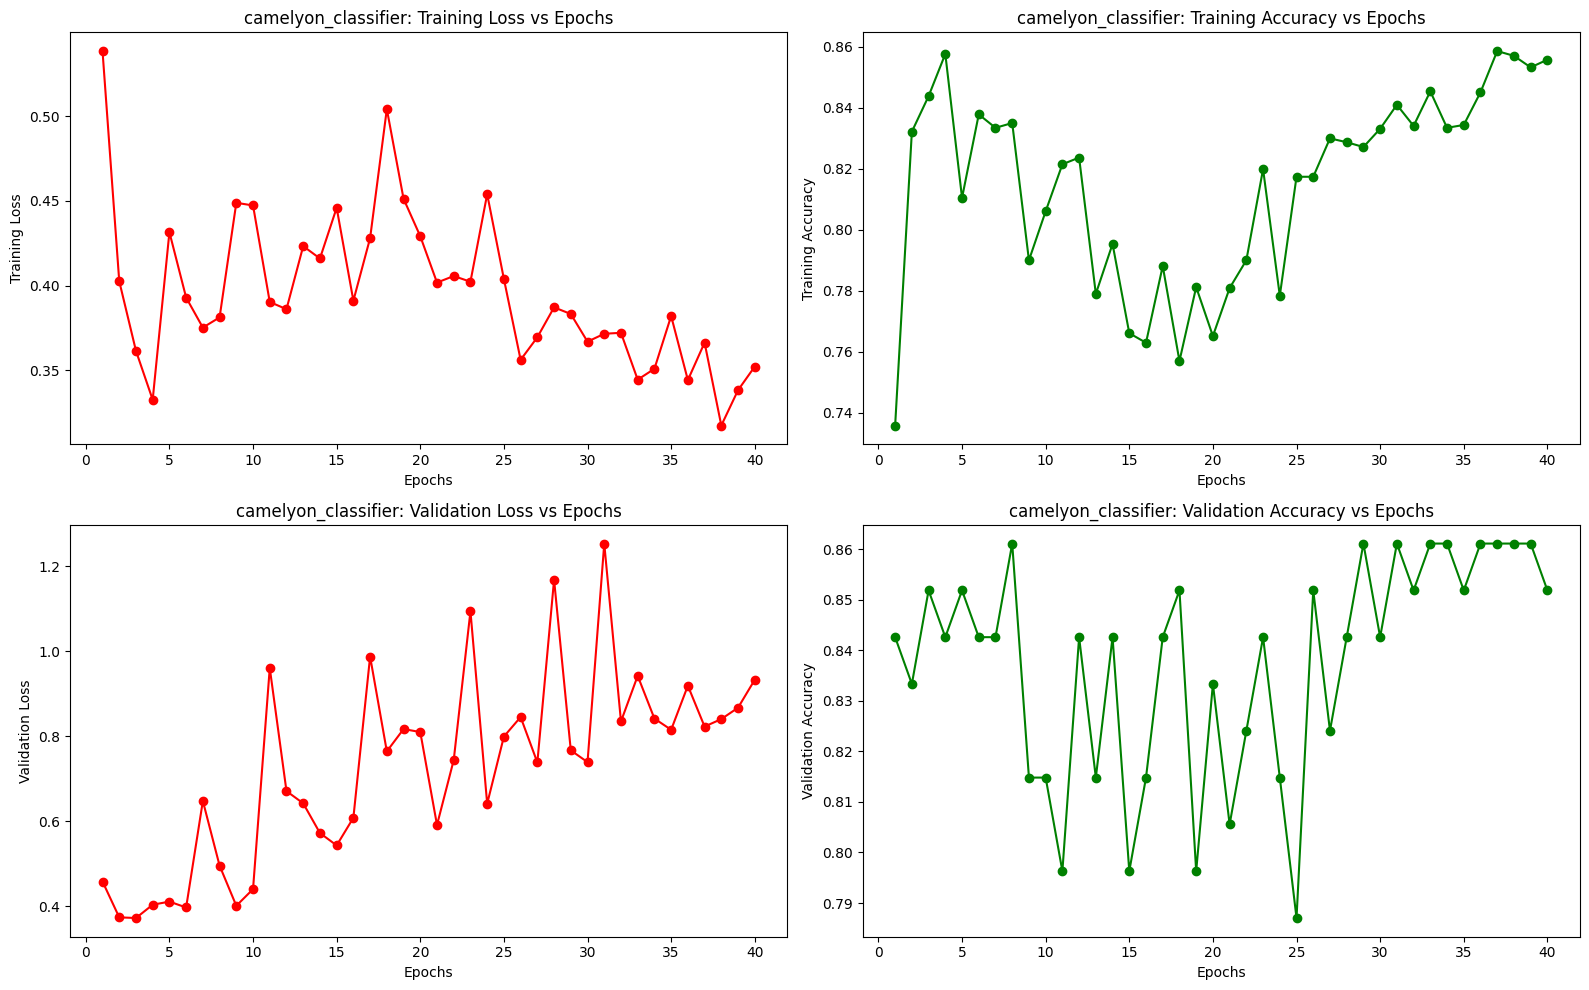

In [50]:
plot_model_stats(name, epoch_numbers, training_losses, validation_losses, training_accuracies, validation_accuracies)